In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline


from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [6]:
!pip install pandas
!pip install tensorflow
!pip install seaborn
import sys
print(sys.executable)
!/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/bin/python -m pip install scikit-learn



/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/bin/python


In [7]:
# set random seed
seed(10)
tf.random.set_seed(10)

In [8]:
import pandas as pd
import numpy as np
a
# Load the specific CSV file
filename = "vibration_normal_5.csv"
merged_data = pd.read_csv(filename)
print(merged_data.head())


   bearingA_x  bearingA_y  bearingB_x  bearingB_y
0   -0.138363    0.028935   -0.019773   -0.002564
1   -0.101087    0.012587   -0.005409    0.015794
2   -0.105067   -0.003972    0.027830    0.026102
3   -0.181645    0.080939   -0.012655    0.050237
4   -0.153244    0.031137   -0.042393    0.046297


In [9]:

train = merged_data[0 : 3000]
test = merged_data[3001 : 4500]
print("Training dataset shaape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (3000, 4)
Test dataset shape: (1499, 4)


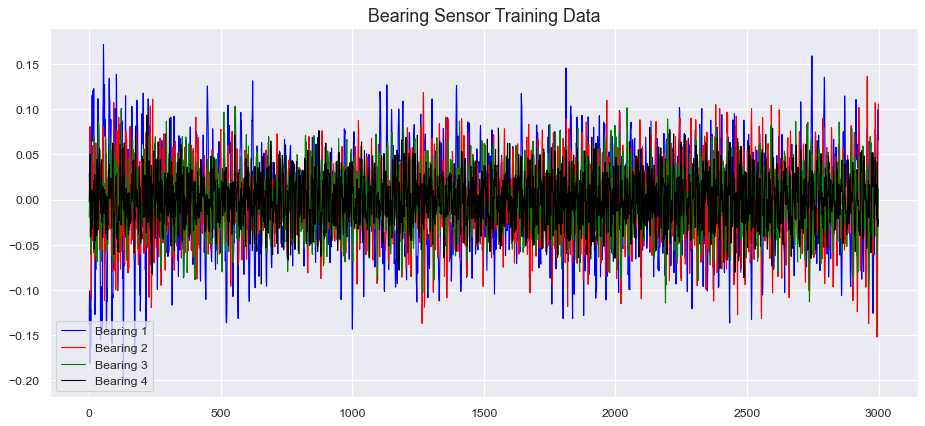

In [10]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['bearingA_x'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['bearingA_y'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['bearingB_x'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['bearingB_y'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

In [11]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)


['scaler_data']

In [12]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (3000, 1, 4)
Test data shape: (1499, 1, 4)


In [13]:
from keras import regularizers
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

def autoencoder_model(X):
    # Input Layer: Accepts input data of shape (timesteps, features)
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    
    # Encoder:
    # First LSTM layer with 16 units, returning sequences.
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.01))(inputs)
    
    # Second LSTM layer with 4 units, returning only the last output.
    L2 = LSTM(4, activation='relu', return_sequences=False,
              kernel_regularizer=regularizers.l2(0.01))(L1)
    
    # RepeatVector: Repeats the 2D output from the second LSTM layer to match the original number of timesteps.
    L3 = RepeatVector(X.shape[1])(L2)
    
    # Decoder:
    # Third LSTM layer with 4 units, returning sequences.
    L4 = LSTM(4, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.01))(L3)
    
    # Fourth LSTM layer with 16 units, returning sequences.
    L5 = LSTM(16, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.01))(L4)
    
    # TimeDistributed: Applies a dense layer to each timestep, reconstructing the original feature dimension.
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    
    # Model Definition: Create the Model object by specifying the input and output layers.
    model = Model(inputs=inputs, outputs=output)
    
    return model


In [14]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 4)           │            68 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,236 (12.64 KB)

 Trainable params: 3,236 (12.64 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history


Epoch 1/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3787 - val_loss: 0.1181
Epoch 2/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.0999 - val_loss: 0.1166
Epoch 3/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 0.0991 - val_loss: 0.1150
Epoch 4/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 0.0983 - val_loss: 0.1134
Epoch 5/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.0976 - val_loss: 0.1118
Epoch 6/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0968 - val_loss: 0.1102
Epoch 7/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 0.0959 - val_loss: 0.1084
Epoch 8/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.0949 - val_loss: 0.1064
Epoch 9/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.0940 - val_loss: 0.1050
Epoch 10/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.0931 - val_loss: 0.1036
Epoch 11/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 0.0923 - val_loss: 0.1024
Epoch 12/100
285/285 ━━

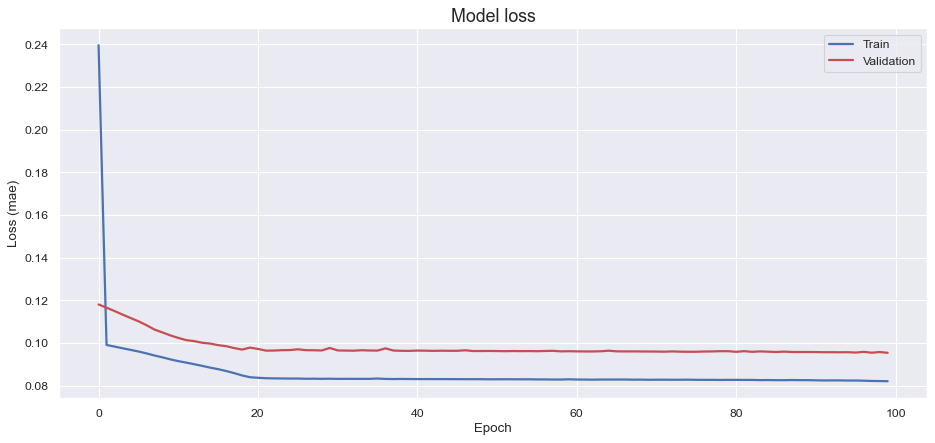

In [16]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/var/folders/sc/vh_dt4bn43z02nv5hd85s7040000gn/T/ipykernel_36340/3269023118.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');


(0.0, 0.5)

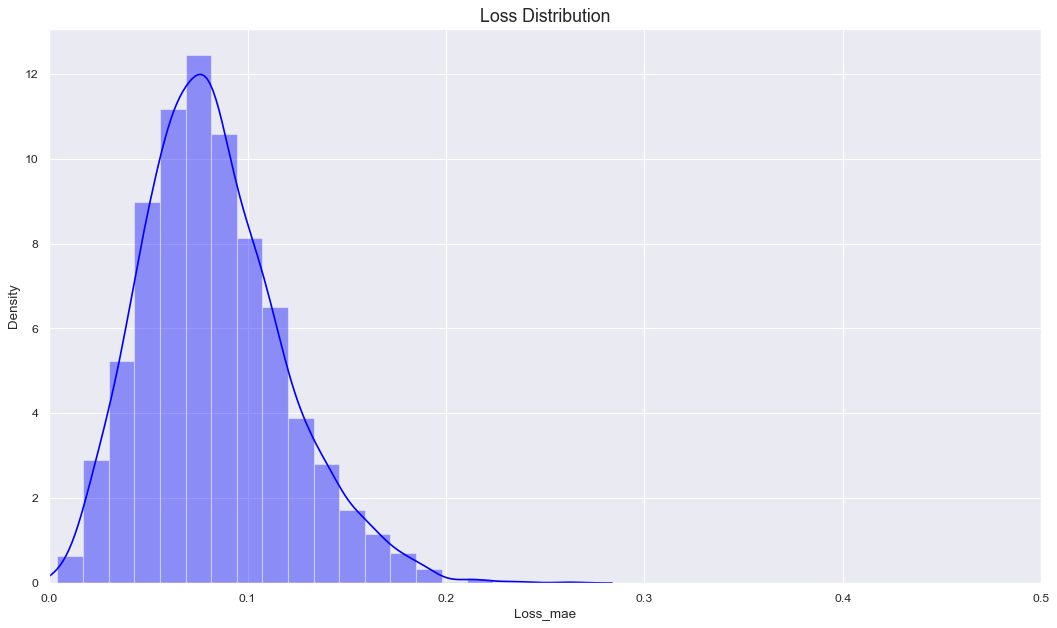

In [17]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

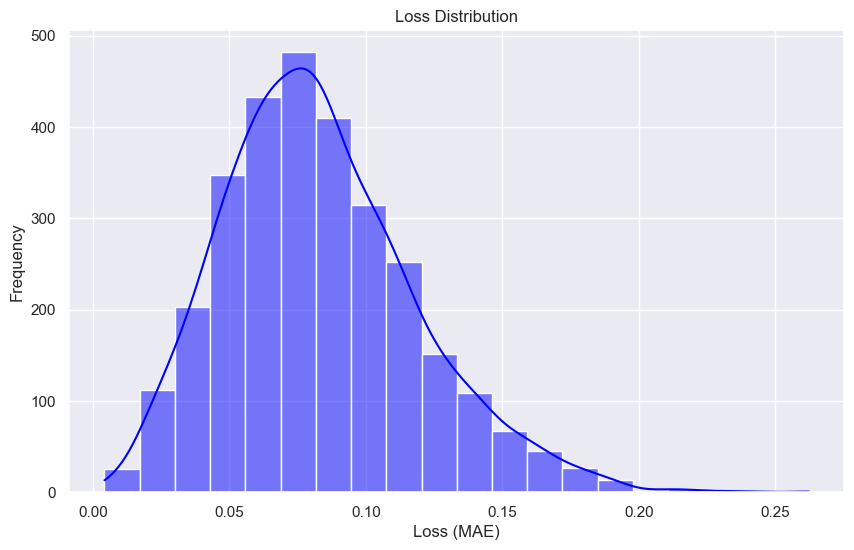

Calculated Threshold: 0.1888416970110986


In [18]:
####
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'scored' DataFrame contains the loss values and threshold column
# Extract the loss values
loss_values = scored['Loss_mae'].values

# Plot the distribution of loss values
plt.figure(figsize=(10, 6))
sns.histplot(loss_values, bins=20, kde=True, color='blue')
plt.title('Loss Distribution')
plt.xlabel('Loss (MAE)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Calculate threshold as mean + 3 * standard deviation
threshold = np.mean(loss_values) + 3 * np.std(loss_values)

# Set the threshold value in the 'Threshold' column of the 'scored' DataFrame
scored['Threshold'] = threshold

# Display the calculated threshold value
print("Calculated Threshold:", threshold)


In [19]:

X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step


,Loss_mae,Threshold,Anomaly
3001,0.031363,0.188842,False
3002,0.122319,0.188842,False
3003,0.075573,0.188842,False
3004,0.046843,0.188842,False
3005,0.108858,0.188842,False


In [20]:
# Define the new row with anomaly
new_row = np.array([[0.02357753755859,	0.0195727475048,	-0.0297993308455521,	-0.00573244633186771]])

# Reshape the new row to match the expected input shape
new_row = new_row.reshape(1, -1)  # Reshape to 2D array with 1 row and 4 columns

# Transform the new row using the scaler
new_row = scaler.transform(new_row)

# Reshape the transformed new row to match the LSTM input shape
new_row = new_row.reshape(1, 1, -1)  # Reshape to 3D array with 1 sample, 1 time step, and 4 features

# Predict the loss for the new row
new_row_pred = model.predict(new_row)

# Reshape the prediction to match the original data shape
new_row_pred = new_row_pred.reshape(new_row_pred.shape[0], new_row_pred.shape[2])

# Calculate the loss for the new row
loss_mae = np.mean(np.abs(new_row_pred - new_row.reshape(new_row.shape[0], new_row.shape[2])), axis=1)



# Determine if the new row contains an anomaly
anomaly = loss_mae > threshold

# Print the result
print("Predicted Loss (MAE):", loss_mae)
print("Threshold:", threshold)
print("Anomaly:", anomaly)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted Loss (MAE): [0.06119793]
Threshold: 0.1888416970110986
Anomaly: [False]


/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [21]:
anomaly=pd.read_csv('vibration_inner_5.csv')
print(anomaly.head)

<bound method NDFrame.head of          bearingA_x  bearingA_y  bearingB_x  bearingB_y
0         -0.470296    1.303063   -1.257638    0.010836
1         -2.384385    0.871887   -0.621608    0.275333
2         -3.909481    0.692718   -1.724610   -0.094608
3         -4.210661    0.475357   -2.995534   -0.151928
4         -4.170751    0.257364   -2.180486   -0.760587
...             ...         ...         ...         ...
7679995    3.252070    2.178292    2.158693   -5.289793
7679996    3.573394    2.043408   -3.551541   -3.965895
7679997    3.643632    0.458431   -9.651953    0.563548
7679998    3.132595   -0.693782   -7.353105    0.361233
7679999    3.375842   -2.103079   -1.600563    1.065823

[7680000 rows x 4 columns]>


In [22]:
import pandas as pd
import numpy as np

# Load the new dataset
new_dataset = pd.read_csv('vibration_inner_5.csv')

# Define the first 100 rows
first_100_rows = new_dataset.iloc[:500]

# Iterate through the first 100 rows
for index, row in first_100_rows.iterrows():
    # Extract the features from the row
    features = row.values.reshape(1, -1)  # Reshape to 2D array with 1 row and 4 columns
    
    # Transform the features using the scaler
    features_scaled = scaler.transform(features)
    
    # Reshape the transformed features to match the LSTM input shape
    features_reshaped = features_scaled.reshape(1, 1, -1)  # Reshape to 3D array with 1 sample, 1 time step, and 4 features
    
    # Predict the loss for the row
    prediction = model.predict(features_reshaped)
    
    # Reshape the prediction to match the original data shape
    prediction = prediction.reshape(prediction.shape[0], prediction.shape[2])
    
    # Calculate the loss for the row
    loss_mae = np.mean(np.abs(prediction - features_scaled), axis=1)


    
    # Determine if the row contains an anomaly
    anomaly = loss_mae > threshold
    
    # Print the result
    print(f"Row {index + 1}:")
    print("Predicted Loss (MAE):", loss_mae)
    print("Threshold:", threshold)
    print("Anomaly:", anomaly)
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Row 1:
Predicted Loss (MAE): [2.76714272]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 2:
Predicted Loss (MAE): [3.24196884]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 3:
Predicted Loss (MAE): [5.22774875]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 4:
Predicted Loss (MAE): [6.78453238]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 5:
Predicted Loss (MAE): [6.4422366]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 6:
Predicted Loss (MAE): [3.59788008]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

Row 7:
Predicted Loss (MAE): [6.39666366]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 8:
Predicted Loss (MAE): [8.87494346]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 9:
Predicted Loss (MAE): [7.9983013]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Row 10:
Predicted Loss (MAE): [4.99897116]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 11:
Predicted Loss (MAE): [1.30725059]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 12:
Predicted Loss (MAE): [1.7694175]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 13:
Predicted Loss (MAE): [1.47186205]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 14:
Predicted Loss (MAE): [3.51765266]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Row 16:
Predicted Loss (MAE): [3.68113457]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 17:
Predicted Loss (MAE): [4.78591364]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Row 18:
Predicted Loss (MAE): [5.48218514]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 19:
Predicted Loss (MAE): [2.70591144]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 20:
Predicted Loss (MAE): [3.25576651]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 21:
Predicted Loss (MAE): [3.87993534]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 22:
Predicted Loss (MAE): [4.1999496]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 23:
Predicted Loss (MAE): [2.44527735]
Threshold: 0.1888416970

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 24:
Predicted Loss (MAE): [4.10308539]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 25:
Predicted Loss (MAE): [2.85056743]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 26:
Predicted Loss (MAE): [3.45272976]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 27:
Predicted Loss (MAE): [4.10031476]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 28:
Predicted Loss (MAE): [2.62928704]
Threshold: 0.1888416970110986
Anomaly: [ True]



/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 29:
Predicted Loss (MAE): [1.98641255]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 30:
Predicted Loss (MAE): [4.30752379]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 31:
Predicted Loss (MAE): [6.64445994]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 32:
Predicted Loss (MAE): [5.17278401]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 33:
Predicted Loss (MAE): [3.07284961]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 34:
Predicted Loss (MAE): [2.5252423]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 35:
Predicted Loss (MAE): [3.53639926]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 36:
Predicted Loss (MAE): [4.5859324]
Threshold: 0.1888416970110

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 39:
Predicted Loss (MAE): [5.0598917]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 40:
Predicted Loss (MAE): [5.22689628]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 41:
Predicted Loss (MAE): [5.00308802]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 42:
Predicted Loss (MAE): [2.82499472]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 43:
Predicted Loss (MAE): [3.59097312]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 44:
Predicted Loss (MAE): [5.23812452]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 45:
Predicted Loss (MAE): [4.34540565]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 46:
Predicted Loss (MAE): [2.51375807]
Threshold: 0.188841697011

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 50:
Predicted Loss (MAE): [2.24308984]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 51:
Predicted Loss (MAE): [4.45873696]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 52:
Predicted Loss (MAE): [3.75192708]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Row 53:
Predicted Loss (MAE): [3.9367182]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 54:
Predicted Loss (MAE): [0.8765534]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 55:
Predicted Loss (MAE): [2.02241119]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 56:
Predicted Loss (MAE): [3.14681196]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Row 57:
Predicted Loss (MAE): [3.11421271]
Threshold: 0.18884169701

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 58:
Predicted Loss (MAE): [2.1976365]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 59:
Predicted Loss (MAE): [3.22220025]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Row 60:
Predicted Loss (MAE): [4.79737828]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 61:
Predicted Loss (MAE): [3.703594]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 62:
Predicted Loss (MAE): [2.92933899]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 63:
Predicted Loss (MAE): [1.57100176]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 64:
Predicted Loss (MAE): [1.78115214]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 65:
Predicted Loss (MAE): [1.48426327]
Threshold: 0.1888416970110

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 66:
Predicted Loss (MAE): [4.86726158]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 67:
Predicted Loss (MAE): [5.96699902]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 68:
Predicted Loss (MAE): [6.02864933]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 69:
Predicted Loss (MAE): [5.39154404]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 70:
Predicted Loss (MAE): [3.42122261]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 71:
Predicted Loss (MAE): [1.62891896]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 72:
Predicted Loss (MAE): [2.14163012]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 73:
Predicted Loss (MAE): [2.74806913]
Threshold: 0.18884169701

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 75:
Predicted Loss (MAE): [0.97270163]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 76:
Predicted Loss (MAE): [1.44835049]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 77:
Predicted Loss (MAE): [1.58526408]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 78:
Predicted Loss (MAE): [2.8496905]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 79:
Predicted Loss (MAE): [2.93735811]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 80:
Predicted Loss (MAE): [1.39245567]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Row 81:
Predicted Loss (MAE): [1.964332]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 82:
Predicted Loss (MAE): [2.10324849]
Threshold: 0.1888416970110

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 84:
Predicted Loss (MAE): [2.72287959]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Row 85:
Predicted Loss (MAE): [2.80820438]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 86:
Predicted Loss (MAE): [2.4520281]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Row 87:
Predicted Loss (MAE): [1.39250762]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 88:
Predicted Loss (MAE): [2.37669359]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 89:
Predicted Loss (MAE): [1.42300823]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 90:
Predicted Loss (MAE): [1.41732109]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 91:
Predicted Loss (MAE): [2.17722858]
Threshold: 0.1888416970

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 92:
Predicted Loss (MAE): [3.08718174]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 93:
Predicted Loss (MAE): [1.56568162]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 94:
Predicted Loss (MAE): [1.57345595]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 95:
Predicted Loss (MAE): [0.94213338]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 96:
Predicted Loss (MAE): [1.63902267]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 97:
Predicted Loss (MAE): [2.84082876]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 98:
Predicted Loss (MAE): [2.1735528]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 99:
Predicted Loss (MAE): [0.5210747]
Threshold: 0.1888416970110

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 101:
Predicted Loss (MAE): [3.11558265]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 102:
Predicted Loss (MAE): [3.14591695]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 103:
Predicted Loss (MAE): [2.54184683]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 104:
Predicted Loss (MAE): [1.99209345]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 105:
Predicted Loss (MAE): [1.86955629]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 106:
Predicted Loss (MAE): [2.33154162]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 107:
Predicted Loss (MAE): [2.08815596]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 108:
Predicted Loss (MAE): [1.10160305]
Threshold: 0.188

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 109:
Predicted Loss (MAE): [1.55333658]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 110:
Predicted Loss (MAE): [2.45668714]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 111:
Predicted Loss (MAE): [3.24346757]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 112:
Predicted Loss (MAE): [2.444073]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 113:
Predicted Loss (MAE): [2.24294535]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 114:
Predicted Loss (MAE): [1.6115429]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 115:
Predicted Loss (MAE): [1.5402718]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 116:
Predicted Loss (MAE): [2.86294904]
Threshold: 0.1888416

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Row 118:
Predicted Loss (MAE): [3.20792818]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 119:
Predicted Loss (MAE): [2.08769708]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 120:
Predicted Loss (MAE): [0.80119477]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 121:
Predicted Loss (MAE): [0.88082557]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 122:
Predicted Loss (MAE): [0.96967467]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 123:
Predicted Loss (MAE): [0.95646766]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 124:
Predicted Loss (MAE): [1.27098588]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 125:
Predicted Loss (MAE): [0.57174217]
Threshold: 0.18

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 127:
Predicted Loss (MAE): [2.13657091]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 128:
Predicted Loss (MAE): [3.25863937]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 129:
Predicted Loss (MAE): [3.60137719]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 130:
Predicted Loss (MAE): [2.9485513]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 131:
Predicted Loss (MAE): [1.36834738]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 132:
Predicted Loss (MAE): [1.91890349]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 133:
Predicted Loss (MAE): [2.91955905]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 134:
Predicted Loss (MAE): [2.17353152]
Threshold: 0.1888

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 135:
Predicted Loss (MAE): [1.23225837]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 136:
Predicted Loss (MAE): [1.19989748]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 137:
Predicted Loss (MAE): [0.64381111]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 138:
Predicted Loss (MAE): [1.54770119]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 139:
Predicted Loss (MAE): [1.97786484]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 140:
Predicted Loss (MAE): [2.12859785]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 141:
Predicted Loss (MAE): [1.39027173]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 142:
Predicted Loss (MAE): [1.94130982]
Threshold: 0.188

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 145:
Predicted Loss (MAE): [1.86445428]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 146:
Predicted Loss (MAE): [1.5698239]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 147:
Predicted Loss (MAE): [0.87822005]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 148:
Predicted Loss (MAE): [2.44995066]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 149:
Predicted Loss (MAE): [4.2584256]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 150:
Predicted Loss (MAE): [2.35587945]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 151:
Predicted Loss (MAE): [1.20794339]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 152:
Predicted Loss (MAE): [1.1213545]
Threshold: 0.188841

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 154:
Predicted Loss (MAE): [1.16816665]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 155:
Predicted Loss (MAE): [2.0567554]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 156:
Predicted Loss (MAE): [2.5812278]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 157:
Predicted Loss (MAE): [1.11572006]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 158:
Predicted Loss (MAE): [1.67243071]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 159:
Predicted Loss (MAE): [0.99870484]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 160:
Predicted Loss (MAE): [1.80843399]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 161:
Predicted Loss (MAE): [2.6745459]
Threshold: 0.188841

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 164:
Predicted Loss (MAE): [1.24636202]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 165:
Predicted Loss (MAE): [0.9454866]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 166:
Predicted Loss (MAE): [1.36460279]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 167:
Predicted Loss (MAE): [1.79232664]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 168:
Predicted Loss (MAE): [2.7122964]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 169:
Predicted Loss (MAE): [2.53198172]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 170:
Predicted Loss (MAE): [1.54740114]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 171:
Predicted Loss (MAE): [0.4829194]
Threshold: 0.188841

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 174:
Predicted Loss (MAE): [1.72498489]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 175:
Predicted Loss (MAE): [2.57294661]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 176:
Predicted Loss (MAE): [2.85795169]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 177:
Predicted Loss (MAE): [2.93148038]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 178:
Predicted Loss (MAE): [2.70967015]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 179:
Predicted Loss (MAE): [1.4586627]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 180:
Predicted Loss (MAE): [1.63102218]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 181:
Predicted Loss (MAE): [2.59904535]
Threshold: 0.1888

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 183:
Predicted Loss (MAE): [1.48235382]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 184:
Predicted Loss (MAE): [1.37678237]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 185:
Predicted Loss (MAE): [2.10678499]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 186:
Predicted Loss (MAE): [1.49114028]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 187:
Predicted Loss (MAE): [1.87601472]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 188:
Predicted Loss (MAE): [2.25849274]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 189:
Predicted Loss (MAE): [2.6024323]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 190:
Predicted Loss (MAE): [2.51826293]
Threshold: 0.1888

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

Row 193:
Predicted Loss (MAE): [2.84652043]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 194:
Predicted Loss (MAE): [3.52346216]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 195:
Predicted Loss (MAE): [2.85725849]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 196:
Predicted Loss (MAE): [2.00509977]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 197:
Predicted Loss (MAE): [0.25137958]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 198:
Predicted Loss (MAE): [0.91449134]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 199:
Predicted Loss (MAE): [1.410003]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 200:
Predicted Loss (MAE): [2.01727284]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 203:
Predicted Loss (MAE): [0.86938554]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 204:
Predicted Loss (MAE): [0.66374881]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 205:
Predicted Loss (MAE): [2.12816997]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 206:
Predicted Loss (MAE): [2.90495365]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 207:
Predicted Loss (MAE): [1.98657694]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 208:
Predicted Loss (MAE): [1.28259709]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 209:
Predicted Loss (MAE): [0.55825681]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 210:
Predicted Loss (MAE): [1.5851232]
Threshold: 0.1888

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 214:
Predicted Loss (MAE): [1.96127045]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 215:
Predicted Loss (MAE): [2.36108745]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 216:
Predicted Loss (MAE): [2.02813001]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 217:
Predicted Loss (MAE): [1.68451575]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 218:
Predicted Loss (MAE): [1.49558519]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 219:
Predicted Loss (MAE): [2.41862034]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 220:
Predicted Loss (MAE): [1.68078623]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 221:
Predicted Loss (MAE): [0.79601567]
Threshold: 0.188

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 224:
Predicted Loss (MAE): [0.97621237]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 225:
Predicted Loss (MAE): [3.08259664]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 226:
Predicted Loss (MAE): [2.68150826]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 227:
Predicted Loss (MAE): [2.37862914]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 228:
Predicted Loss (MAE): [2.42725063]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 229:
Predicted Loss (MAE): [2.07942445]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 230:
Predicted Loss (MAE): [1.19872773]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 231:
Predicted Loss (MAE): [1.07664368]
Threshold: 0.188

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 235:
Predicted Loss (MAE): [0.12342936]
Threshold: 0.1888416970110986
Anomaly: [False]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 236:
Predicted Loss (MAE): [1.72875152]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 237:
Predicted Loss (MAE): [1.5145031]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 238:
Predicted Loss (MAE): [1.48077656]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 239:
Predicted Loss (MAE): [1.07059675]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 240:
Predicted Loss (MAE): [0.67461768]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 241:
Predicted Loss (MAE): [1.89752918]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 242:
Predicted Loss (MAE): [1.18588419]
Threshold: 0.1888

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 246:
Predicted Loss (MAE): [1.39596555]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 247:
Predicted Loss (MAE): [0.93432203]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 248:
Predicted Loss (MAE): [1.35405014]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 249:
Predicted Loss (MAE): [0.6767703]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 250:
Predicted Loss (MAE): [1.27659324]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 251:
Predicted Loss (MAE): [2.37557409]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 252:
Predicted Loss (MAE): [1.9860824]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 253:
Predicted Loss (MAE): [2.76481055]
Threshold: 0.18884

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 257:
Predicted Loss (MAE): [1.19768395]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 258:
Predicted Loss (MAE): [0.62336019]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 259:
Predicted Loss (MAE): [0.45253644]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 260:
Predicted Loss (MAE): [1.49118287]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 261:
Predicted Loss (MAE): [1.54329671]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 262:
Predicted Loss (MAE): [2.3056922]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 263:
Predicted Loss (MAE): [2.60492558]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 264:
Predicted Loss (MAE): [3.50325785]
Threshold: 0.1888

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 268:
Predicted Loss (MAE): [7.92183597]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 269:
Predicted Loss (MAE): [8.10883033]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 270:
Predicted Loss (MAE): [5.76322936]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 271:
Predicted Loss (MAE): [4.78573603]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 272:
Predicted Loss (MAE): [5.03623174]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 273:
Predicted Loss (MAE): [3.6626972]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 274:
Predicted Loss (MAE): [0.85202016]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 275:
Predicted Loss (MAE): [2.86834056]
Threshold: 0.1888

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 279:
Predicted Loss (MAE): [7.92225245]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 280:
Predicted Loss (MAE): [5.60703124]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 281:
Predicted Loss (MAE): [7.10191559]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 282:
Predicted Loss (MAE): [14.33335885]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 283:
Predicted Loss (MAE): [12.66538636]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 284:
Predicted Loss (MAE): [10.16589142]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 285:
Predicted Loss (MAE): [12.26300028]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 286:
Predicted Loss (MAE): [6.39215397]
Threshold: 0

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 290:
Predicted Loss (MAE): [14.14767562]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 291:
Predicted Loss (MAE): [17.27349494]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 292:
Predicted Loss (MAE): [13.79703945]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 293:
Predicted Loss (MAE): [11.09268128]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 294:
Predicted Loss (MAE): [10.35489523]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 295:
Predicted Loss (MAE): [6.24957071]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 296:
Predicted Loss (MAE): [4.52034124]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 297:
Predicted Loss (MAE): [7.77736018]
Threshold: 

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 301:
Predicted Loss (MAE): [5.9565553]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 302:
Predicted Loss (MAE): [8.70288389]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 303:
Predicted Loss (MAE): [6.98904773]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 304:
Predicted Loss (MAE): [4.71337808]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 305:
Predicted Loss (MAE): [6.621783]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 306:
Predicted Loss (MAE): [8.50801292]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 307:
Predicted Loss (MAE): [8.94882176]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 308:
Predicted Loss (MAE): [6.30076527]
Threshold: 0.188841

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 312:
Predicted Loss (MAE): [10.36111468]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 313:
Predicted Loss (MAE): [7.56107678]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 314:
Predicted Loss (MAE): [5.18042003]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 315:
Predicted Loss (MAE): [4.17400763]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 316:
Predicted Loss (MAE): [2.5032042]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 317:
Predicted Loss (MAE): [3.93275674]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 318:
Predicted Loss (MAE): [4.82669198]
Threshold: 0.1888416970110986
Anomaly: [ True]



/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 319:
Predicted Loss (MAE): [7.68526518]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 320:
Predicted Loss (MAE): [10.4460859]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 321:
Predicted Loss (MAE): [10.53447049]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 322:
Predicted Loss (MAE): [7.42573858]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 323:
Predicted Loss (MAE): [1.80685726]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 324:
Predicted Loss (MAE): [3.02729105]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 325:
Predicted Loss (MAE): [4.51809821]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 326:
Predicted Loss (MAE): [5.54194478]
Threshold: 0.18

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 329:
Predicted Loss (MAE): [5.07143181]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 330:
Predicted Loss (MAE): [6.18981181]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 331:
Predicted Loss (MAE): [6.10235282]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 332:
Predicted Loss (MAE): [3.80580671]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 333:
Predicted Loss (MAE): [2.54693691]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 334:
Predicted Loss (MAE): [3.11038091]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 335:
Predicted Loss (MAE): [2.74904462]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 336:
Predicted Loss (MAE): [3.59014332]
Threshold: 0.188

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 340:
Predicted Loss (MAE): [5.70902428]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Row 341:
Predicted Loss (MAE): [4.33396076]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 342:
Predicted Loss (MAE): [2.46940354]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 343:
Predicted Loss (MAE): [5.81387308]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 344:
Predicted Loss (MAE): [6.13920563]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 345:
Predicted Loss (MAE): [5.46327303]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 346:
Predicted Loss (MAE): [5.23040879]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 347:
Predicted Loss (MAE): [4.94379745]
Threshold: 0.188

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 350:
Predicted Loss (MAE): [5.24670145]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 351:
Predicted Loss (MAE): [7.05854996]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 352:
Predicted Loss (MAE): [7.04260268]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 353:
Predicted Loss (MAE): [5.86756799]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 354:
Predicted Loss (MAE): [3.31110503]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 355:
Predicted Loss (MAE): [3.08910317]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 356:
Predicted Loss (MAE): [3.65133558]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 357:
Predicted Loss (MAE): [2.9377044]
Threshold: 0.1888

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 360:
Predicted Loss (MAE): [3.37124013]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 361:
Predicted Loss (MAE): [1.44784762]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 362:
Predicted Loss (MAE): [1.67580776]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 363:
Predicted Loss (MAE): [2.44658845]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 364:
Predicted Loss (MAE): [2.2678142]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 365:
Predicted Loss (MAE): [3.20906841]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 366:
Predicted Loss (MAE): [2.69136778]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 367:
Predicted Loss (MAE): [2.78599928]
Threshold: 0.1888

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 369:
Predicted Loss (MAE): [4.55379416]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 370:
Predicted Loss (MAE): [2.00226262]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 371:
Predicted Loss (MAE): [1.36421761]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 372:
Predicted Loss (MAE): [1.65877678]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 373:
Predicted Loss (MAE): [2.76354608]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 374:
Predicted Loss (MAE): [4.04371986]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 375:
Predicted Loss (MAE): [4.56297232]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 376:
Predicted Loss (MAE): [3.40225548]
Threshold: 0.188

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 380:
Predicted Loss (MAE): [2.73806467]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 381:
Predicted Loss (MAE): [4.49866878]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 382:
Predicted Loss (MAE): [5.39308041]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 383:
Predicted Loss (MAE): [5.61234636]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 384:
Predicted Loss (MAE): [4.88323606]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 385:
Predicted Loss (MAE): [3.32542959]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 386:
Predicted Loss (MAE): [4.85072349]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 387:
Predicted Loss (MAE): [4.49988197]
Threshold: 0.188

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 391:
Predicted Loss (MAE): [4.95521102]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 392:
Predicted Loss (MAE): [4.6069994]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 393:
Predicted Loss (MAE): [4.11429474]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 394:
Predicted Loss (MAE): [4.29689479]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 395:
Predicted Loss (MAE): [4.40796537]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 396:
Predicted Loss (MAE): [3.5346026]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 397:
Predicted Loss (MAE): [2.15698539]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 398:
Predicted Loss (MAE): [2.29018011]
Threshold: 0.18884

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 402:
Predicted Loss (MAE): [2.48442805]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 403:
Predicted Loss (MAE): [1.26100377]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 404:
Predicted Loss (MAE): [0.88935736]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 405:
Predicted Loss (MAE): [1.40930574]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 406:
Predicted Loss (MAE): [2.21568262]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 407:
Predicted Loss (MAE): [2.27866274]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 408:
Predicted Loss (MAE): [1.80381207]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 409:
Predicted Loss (MAE): [1.75940539]
Threshold: 0.188

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 413:
Predicted Loss (MAE): [4.3434705]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 414:
Predicted Loss (MAE): [5.4134322]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 415:
Predicted Loss (MAE): [4.16366223]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 416:
Predicted Loss (MAE): [3.16438478]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 417:
Predicted Loss (MAE): [1.83518285]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 418:
Predicted Loss (MAE): [0.33251928]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 419:
Predicted Loss (MAE): [1.92990236]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 420:
Predicted Loss (MAE): [3.04704055]
Threshold: 0.18884

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 424:
Predicted Loss (MAE): [4.53321602]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 425:
Predicted Loss (MAE): [2.56549539]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 426:
Predicted Loss (MAE): [2.29000915]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 427:
Predicted Loss (MAE): [2.57789191]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 428:
Predicted Loss (MAE): [2.34326016]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 429:
Predicted Loss (MAE): [2.53218801]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 430:
Predicted Loss (MAE): [2.68755442]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 431:
Predicted Loss (MAE): [2.7935924]
Threshold: 0.1888

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 435:
Predicted Loss (MAE): [0.97855305]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 436:
Predicted Loss (MAE): [1.81595214]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 437:
Predicted Loss (MAE): [2.02505724]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 438:
Predicted Loss (MAE): [2.02372932]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 439:
Predicted Loss (MAE): [1.20362629]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 440:
Predicted Loss (MAE): [1.24374498]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 441:
Predicted Loss (MAE): [1.88669014]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 442:
Predicted Loss (MAE): [1.22597282]
Threshold: 0.188

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

Row 445:
Predicted Loss (MAE): [2.70696638]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 446:
Predicted Loss (MAE): [2.93201815]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 447:
Predicted Loss (MAE): [2.16609928]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 448:
Predicted Loss (MAE): [0.92813607]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 449:
Predicted Loss (MAE): [0.93440455]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 450:
Predicted Loss (MAE): [1.92413626]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 451:
Predicted Loss (MAE): [2.26559274]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 452:
Predicted Loss (MAE): [2.09372064]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 456:
Predicted Loss (MAE): [1.47377618]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 457:
Predicted Loss (MAE): [1.18355896]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 458:
Predicted Loss (MAE): [1.95516698]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 459:
Predicted Loss (MAE): [2.98395105]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 460:
Predicted Loss (MAE): [3.52506273]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 461:
Predicted Loss (MAE): [3.29676198]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 462:
Predicted Loss (MAE): [2.39120655]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 463:
Predicted Loss (MAE): [1.37825899]
Threshold: 0.188

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 467:
Predicted Loss (MAE): [2.12325425]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 468:
Predicted Loss (MAE): [1.9598029]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 469:
Predicted Loss (MAE): [2.01118383]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 470:
Predicted Loss (MAE): [2.5007649]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 471:
Predicted Loss (MAE): [2.83573522]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 472:
Predicted Loss (MAE): [2.21802702]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 473:
Predicted Loss (MAE): [1.61769671]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 474:
Predicted Loss (MAE): [0.56266091]
Threshold: 0.18884

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 478:
Predicted Loss (MAE): [2.89311462]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 479:
Predicted Loss (MAE): [1.89269869]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 480:
Predicted Loss (MAE): [1.85745615]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 481:
Predicted Loss (MAE): [2.01093883]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 482:
Predicted Loss (MAE): [2.03616005]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 483:
Predicted Loss (MAE): [2.35814147]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 484:
Predicted Loss (MAE): [2.42956421]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 485:
Predicted Loss (MAE): [2.39341098]
Threshold: 0.188

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Row 489:
Predicted Loss (MAE): [2.93063396]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 490:
Predicted Loss (MAE): [2.96784605]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 491:
Predicted Loss (MAE): [2.80280714]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 492:
Predicted Loss (MAE): [4.31769233]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 493:
Predicted Loss (MAE): [2.96250086]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 494:
Predicted Loss (MAE): [1.50436123]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 495:
Predicted Loss (MAE): [0.59531564]
Threshold: 0.1888416970110986
Anomaly: [ True]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 496:
Predicted Loss (MAE): [1.1062091]
Threshold: 0.1888

/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Row 500:
Predicted Loss (MAE): [1.84004833]
Threshold: 0.1888416970110986
Anomaly: [ True]



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 1, 4)           │            68 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,236 (12.64 KB)

 Trainable params: 3,236 (12.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4205 - val_loss: 0.1407
Epoch 2/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 0.1174 - val_loss: 0.1357
Epoch 3/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.1158 - val_loss: 0.1358
Epoch 4/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 0.1159 - val_loss: 0.1358
Epoch 5/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.1159 - val_loss: 0.1358
Epoch 6/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 0.1159 - val_loss: 0.1358
Epoch 7/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 0.1159 - val_loss: 0.1358
Epoch 8/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.1159 - val_loss: 0.1358
Epoch 9/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.1159 - val_loss: 0.1358
Epoch 10/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 0.1159 - val_loss: 0.1358
Epoch 11/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 0.1159 - val_loss: 0.1358
Epoch 12/100
285/285 

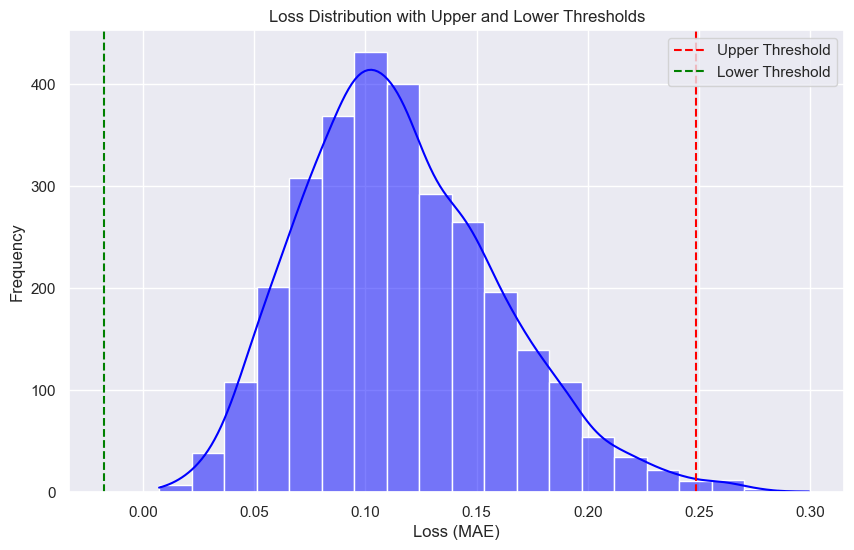

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
      Loss_mae  Anomaly
3001  0.041749    False
3002  0.124916    False
3003  0.138797    False
3004  0.155052    False
3005  0.188655    False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predicted Loss (MAE): [0.07845025]
Upper Threshold: 0.2488026615201683
Lower Threshold: -0.01726132539927841
Anomaly: [False]


/opt/homebrew/Cellar/jupyterlab/4.1.3/libexec/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras import regularizers
import joblib

# Assuming train and test datasets are already loaded and preprocessed
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

# Reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

# Calculate reconstruction errors for training data
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train - Xtrain), axis=1)

# Calculate the mean and standard deviation of the reconstruction errors
mean_loss = np.mean(scored_train['Loss_mae'])
std_loss = np.std(scored_train['Loss_mae'])

# Set the upper and lower thresholds
upper_threshold = mean_loss + 3 * std_loss
lower_threshold = mean_loss - 3 * std_loss

# Visualize the loss distribution and thresholds
plt.figure(figsize=(10, 6))
sns.histplot(scored_train['Loss_mae'], bins=20, kde=True, color='blue')
plt.axvline(upper_threshold, color='red', linestyle='--', label='Upper Threshold')
plt.axvline(lower_threshold, color='green', linestyle='--', label='Lower Threshold')
plt.title('Loss Distribution with Upper and Lower Thresholds')
plt.xlabel('Loss (MAE)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Calculate reconstruction errors for test data
X_pred_test = model.predict(X_test)
X_pred_test = X_pred_test.reshape(X_pred_test.shape[0], X_pred_test.shape[2])
X_pred_test = pd.DataFrame(X_pred_test, columns=test.columns)
X_pred_test.index = test.index

scored_test = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored_test['Loss_mae'] = np.mean(np.abs(X_pred_test - Xtest), axis=1)

# Classify anomalies based on the thresholds
scored_test['Anomaly'] = (scored_test['Loss_mae'] > upper_threshold) | (scored_test['Loss_mae'] < lower_threshold)

# Display the results
print(scored_test.head())

# Define the new row with anomaly
new_row = np.array([[0.02357753755859, 0.0195727475048, -0.0297993308455521, -0.00573244633186771]])

# Reshape and transform the new row
new_row = new_row.reshape(1, -1)  # Reshape to 2D array with 1 row and 4 columns
new_row = scaler.transform(new_row)
new_row = new_row.reshape(1, 1, -1)  # Reshape to 3D array with 1 sample, 1 time step, and 4 features

# Predict the loss for the new row
new_row_pred = model.predict(new_row)
new_row_pred = new_row_pred.reshape(new_row_pred.shape[0], new_row_pred.shape[2])
loss_mae = np.mean(np.abs(new_row_pred - new_row.reshape(new_row.shape[0], new_row.shape[2])), axis=1)

# Determine if the new row contains an anomaly
anomaly = (loss_mae > upper_threshold) | (loss_mae < lower_threshold)

# Print the result
print("Predicted Loss (MAE):", loss_mae)
print("Upper Threshold:", upper_threshold)
print("Lower Threshold:", lower_threshold)
print("Anomaly:", anomaly)


   bearingA_x  bearingA_y  bearingB_x  bearingB_y
0   -0.138363    0.028935   -0.019773   -0.002564
1   -0.101087    0.012587   -0.005409    0.015794
2   -0.105067   -0.003972    0.027830    0.026102
3   -0.181645    0.080939   -0.012655    0.050237
4   -0.153244    0.031137   -0.042393    0.046297
Training dataset shape: (5000, 4)
Test dataset shape: (1499, 4)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 1, 4)           │            68 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,236 (12.64 KB)

 Trainable params: 3,236 (12.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4981 - val_loss: 0.1264
Epoch 2/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 0.1083 - val_loss: 0.1215
Epoch 3/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 0.1077 - val_loss: 0.1214
Epoch 4/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 0.1078 - val_loss: 0.1213
Epoch 5/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1075 - val_loss: 0.1211
Epoch 6/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 0.1072 - val_loss: 0.1215
Epoch 7/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 0.1077 - val_loss: 0.1214
Epoch 8/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 0.1076 - val_loss: 0.1218
Epoch 9/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1077 - val_loss: 0.1213
Epoch 10/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1061 - val_loss: 0.1212
Epoch 11/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1075 - val_loss: 0.1213
Epoch 12/100
475/475 ━━━━━━━━

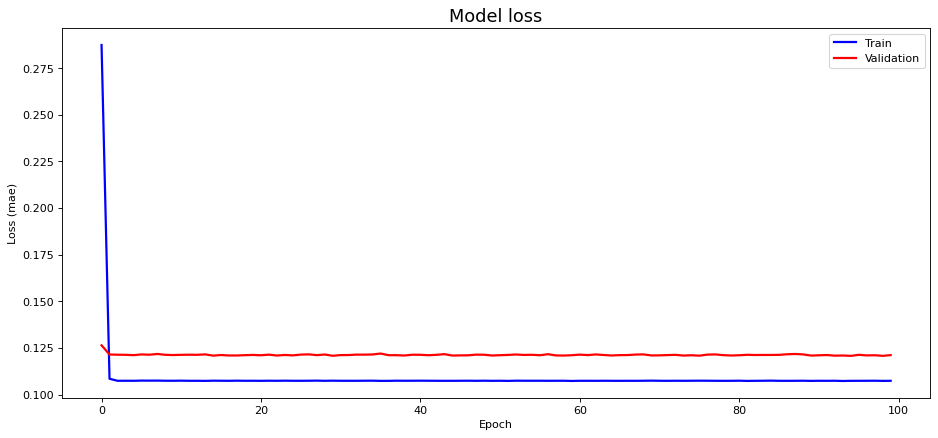

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Dense, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Load the specific CSV file
filename = "/Users/amoggha03/Desktop/College/L&T/Dataset/vibration_normal_5.csv"
merged_data = pd.read_csv(filename)
print(merged_data.head())

# Split into training and test sets
train = merged_data[0:5000]
test = merged_data[3001:4500]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

# Scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

# Reshape the input data for LSTM model
number_of_features = X_train.shape[1]  # Number of columns in your dataframe
number_of_time_steps = 1  # Assuming each row represents a sample

X_train = X_train.reshape(X_train.shape[0], number_of_time_steps, number_of_features)
X_test = X_test.reshape(X_test.shape[0], number_of_time_steps, number_of_features)

# Define autoencoder model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False, kernel_regularizer=regularizers.l2(0.01))(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

# Train the model
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history

# Plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()



157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/var/folders/sc/vh_dt4bn43z02nv5hd85s7040000gn/T/ipykernel_60989/2173975684.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins=20, kde=True, color='blue')


,Loss_mae,Anomaly
3001,0.038100,False
3002,0.108008,False
3003,0.116313,False
3004,0.123282,False
3005,0.153872,True


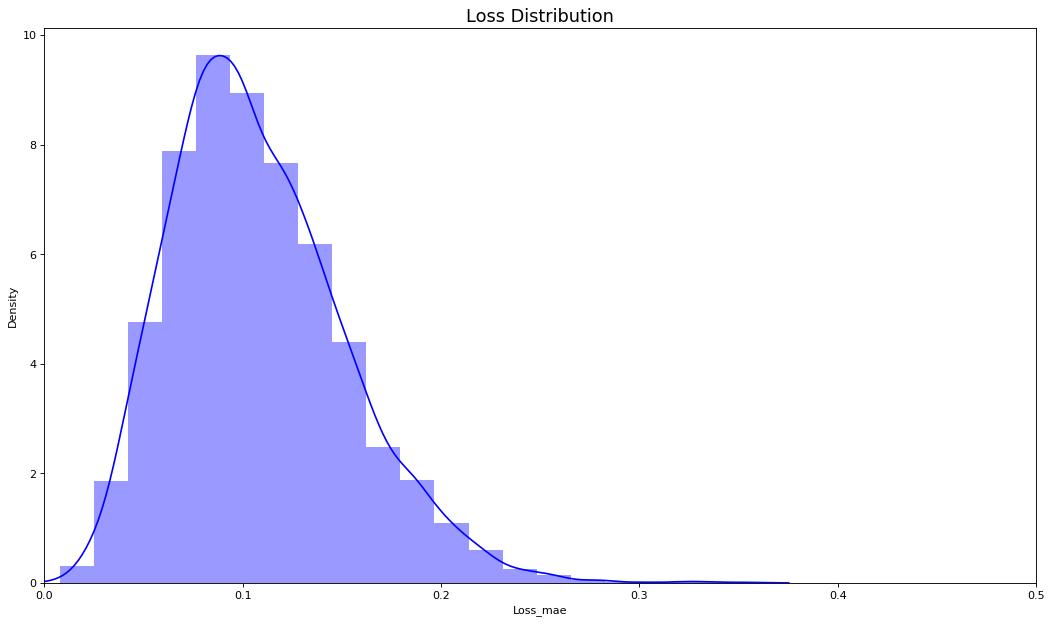

In [6]:
# Evaluate the model
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred - Xtrain), axis=1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins=20, kde=True, color='blue')
plt.xlim([0.0, .5])

# Detect anomalies
# Detect anomalies
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred - Xtest), axis=1)

# Define the threshold based on the mean loss value
threshold = scored['Loss_mae'].mean()

# Detect anomalies using the threshold
scored['Anomaly'] = scored['Loss_mae'] > threshold
scored.head()


In [12]:
# Assuming you have loaded your test data into X_test and labeled it appropriately
# Assuming scored dataframe contains the reconstruction error (Loss_mae) and predicted anomalies (Anomaly)

# Extract the predicted labels from the 'Anomaly' column
predicted_labels = scored['Anomaly']

# Extract the actual labels (anomalies) from the 'Loss_mae' column based on a threshold
threshold = scored['Loss_mae'].mean()
actual_labels = scored['Loss_mae'] > threshold

# Convert boolean values to 0 and 1 (0 for normal, 1 for anomaly)
actual_labels = actual_labels.astype(int)

# Calculate accuracy
accuracy = np.mean(actual_labels == predicted_labels) * 100
print("Accuracy of the AutoEncoder Model on Test Daatset: {:.2f}%".format(accuracy))


Accuracy of the AutoEncoder Model on Test Daatset: 100.00%
